# Analyze properties of the interface of the propagating front of OsxGFP positive cells
## (1) Interface dynamics

<b>Version control</b><br>

Method 1 (method 2 for static images): overhang control. Use thresholded binary image, take largest contiguous region.
Method 2: Use phi_X method from Podewitz et al. (2016) to analyze moment equations. 
Method 3: threshold-independent method of defining interface.

In [11]:
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pandas import DataFrame
from numpy import fft
import os
cwd = os.getcwd(); print("Working dir: " + cwd)

video = 4; video_idx = video-1; # python index
dates_all = ["190305", "190314", "200120", "170902"];
date = dates_all[video_idx];
folder_data = "/Users/dang/Documents/TablerLab/Data_Live_Imaging/{} Live Imaging/".format(date);
print("Save data in: " + folder_data)
folder_figures = os.path.split(cwd)[0] + "/Figures/Live_Imaging_{}/1d_interface_dynamics_method3/".format(date); 
print("Save plots in: " + folder_figures)

Working dir: /Users/dang/Documents/TablerLab/Code
Save data in: /Users/dang/Documents/TablerLab/Data_Live_Imaging/170902 Live Imaging/
Save plots in: /Users/dang/Documents/TablerLab/Figures/Live_Imaging_170902/1d_interface_dynamics_method3/


In [40]:
# --- Image settings ---
# Total image size in pixels
#size_px = np.array([3782, 2882]); # 190305
#size_px = np.array([5612, 2850]); # 190314/190315 after pruning
# To be precise, 190314: [5612, 2871] and 190315: [5606, 2880] 
# size_px = np.array([4734, 3925]); # 200120
size_px_all = np.array([[3782, 2882], [5612, 2850], [4734, 3925], [4643, 2886]]);

# Number of pixels per micron
#pix_per_micron = 4.400; # 190305
#pix_per_micron = 5.1040; # 190314
#pix_per_micron = 5.1040; # 200120
pix_per_micron_all = [4.400, 5.1040, 5.1040, 4.4034];

# Pixel range selection
# Crop out part of the picture where the interface bends or deviates too much from the rest
# [a, b] -> take a slice between indices a and b. None=no bound
x_pixel_range_all = [[30, None], [None, -20], [20, None], [20, None]]; 
# y_pixel_range_all = [[0, -150], [0, None], [700, -75]]; # used for other methods
y_pixel_range_all = [[30, -500], [20, -40], [730, -75], [300, -20]];

# Total size of image in microns
#size = np.array([859.55, 655]); # 190305
#size = np.array([1099.53, 562.5]); # 190314
#size = np.array([1098.35, 564.26]); # 190315
#size = np.array([927.51, 769.01]); # 200120

# Default image label
#im_label = "190305_MaxProjected_Stitched_dataset(0-12hr)_YD";
#im_label = "MaxProjected_Stitched_Blurred_190305_ML1_OsxGFP_Explant_Video_1(0-12hr)_YD";
#im_label = "MaxProjected_Stitched_190314_ML1_OsxGFP_Explant_Video_1_(0-16hr)";
#im_label = "MaxProjected_Stitched_200120_Live_Imaging_OsxGFP_E1375_12_hours";
im_label_all = ["190305_MaxProjected_Stitched_dataset(0-12hr)_YD", 
                "MaxProjected_Stitched_190314_ML1_OsxGFP_Explant_Video_1_(0-16hr)",
                "MaxProjected_Stitched_200120_Live_Imaging_OsxGFP_E1375_12_hours",
               "MAX_BLUR_20200414AQR_osx_E13.5_020917.lif - TileScan_003_Merging"];

# Set parameters
im_label = im_label_all[video_idx];
pix_per_micron = pix_per_micron_all[video_idx];
size_px = size_px_all[video_idx];
x_pix_range = x_pixel_range_all[video_idx];
y_pix_range = y_pixel_range_all[video_idx];
#Lx = size_px[0];
#Ly = size_px[1];

### Load full image data

Note: why are values in range 0-256 for a 16-bit image?

In [14]:
from skimage import io
folder = "/Users/dang/Documents/TablerLab/Data_Live_Imaging/Original datasets/{} Live Imaging/".format(date);
# names of video (tif) files
fname_all = ["MaxProjected_Stitched_Blurred_190305_ML1_OsxGFP_Explant_Video_1(0-12hr).tif",
             ["MaxProjected_Stitched_190314 ML1 OsxGFP Explant Video 1 (0-8hr).tif", 
              "MaxProjected_Stitched_190314 ML1 OsxGFP Explant Video 2 (8-16hr).tif"],
             "MaxProjected_Stitched_200120 Live Imaging OsxGFP E1375 12 hours.tif",
            "MAX_BLUR_20200414AQR_osx_E13.5_020917.lif - TileScan_003_Merging.tif"];

if video_idx!=1:
    fname = fname_all[video_idx]
    #img=mpimg.imread(folder + fname)
    img = io.imread(folder + fname)
else: # exception for video 2 (stich together from 2 files)
    t_max = 98;
    Lx = 5606;
    Ly = 2871;
    img = np.zeros([t_max, Ly, Lx]);

    fname1 = fname_all[1][0];
    fname2 = fname_all[1][1];
    
    img1 = io.imread(folder + fname1);
    img2 = io.imread(folder + fname2);
    
    img[:img1.shape[0]] = img1[:, :Ly, :Lx];
    img[img1.shape[0]:] = img2[:, :Ly, :Lx];    

In [41]:
# slice image
img_sliced = img[:, y_pix_range[0]:y_pix_range[1], x_pix_range[0]:x_pix_range[1]];
Lx = img_sliced.shape[2]; # size of slices image
Ly = img_sliced.shape[1];

# convert from uint16 to int64
img_sliced = img_sliced.astype(int);

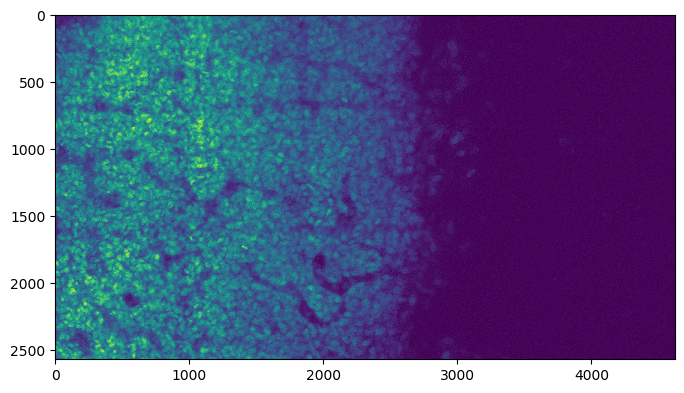

In [42]:
plt.figure(dpi=100, figsize=(8,8));
sl = 0; # slice to show
plt.imshow(img_sliced[sl,:,:])
#plt.colorbar();
plt.show()

In [43]:
# Check if slicing is good enough
# Condition: for every row (y-value), first and last value cannot be same
t_max = img_sliced.shape[0];
for t_idx in range(t_max):
    W_y = (img_sliced[t_idx,:,-1]-img_sliced[t_idx,:,0]);    
    if np.sum(W_y==0)!=0:
        print("Error at time slice ", t_idx+1)
        print("First error at y=", np.argwhere(W_y==0)[0])        

# Parameter-independent interface definition

<b>Given</b>: input signal consists of intensity values $S(x, y)$ at different locations $x, y$. Suppose that $S(x=0, y) \leq S(x=L_X, y)$ for all $y$, and "generally" $\partial_x S(x, y) \geq 0$ (needs to be made more precise). <br>

<b>Key assumption</b>: Probabiliy of finding interface height $h(y)$ equals $P[h(y)=x] = \partial_x S(x,y)$.

Define normalizations <br>
$\hspace{1cm} W(y) = \int S(x,y) \, dx $ <br>
$\hspace{1cm} S = \int \int S(x,y) \, dx \, dy $ <br>

Then: <br>
$\hspace{1cm} \langle h(y) \rangle = \frac{1}{W(y)} \int x \, \partial_x S(x,y) dx$ <br>
$\hspace{1cm} \langle h(y)^2 \rangle = \frac{1}{W(y)} \int x^2 \, \partial_x S(x,y) dx$,
where $\langle \ldots \rangle$ denotes averages over $x$. 

Hence, <br>
$\hspace{1cm} \langle \langle h(y) \rangle_{x} \rangle_{y} = \frac{1}{S} \int h(y) W(y) dy$ <br>
$\hspace{1cm} \langle \langle h(y)^2 \rangle_{x} \rangle_{y} = \frac{1}{S} \int h(y)^2 W(y) dy$ <br>
$\hspace{1cm} \text{Width} = \sqrt{\langle \langle h(y)^2 \rangle_{x} \rangle_{y} - \langle \langle h(y) \rangle_{x} \rangle_{y}^2}$


In [44]:
sign = -1; # CAUTION: sign=1 if intensities increase with x, -1 if decrease
t_max = img_sliced.shape[0];

h_all = np.zeros(t_max);
w_all = np.zeros(t_max);
hy_all = np.zeros([t_max, Ly]);

for t_idx in range(t_max):
    #print(t_idx);
    signal_all = img_sliced[t_idx];

    # derivatives
    S_xy_p_all = sign*np.diff(signal_all, axis=1); # partial_x S(x,y)

    # normalization terms
    #W_y = np.sum(signal_all, axis=1);
    W_y = sign*(signal_all[:,-1]-signal_all[:,0]);
    S = np.sum(W_y);

    # Calculate h(y)
    x_mat = np.array([np.arange(1/2, Lx-1) for _ in range(Ly)]); # chooses interval mid-points 1/2, 3/2, 5/2, etc.
    h_y = np.sum(x_mat*S_xy_p_all, axis=1)/W_y;

    # Calculate h, w
    h = np.sum(h_y*W_y)/S;
    h2 = np.sum(h_y**2*W_y)/S;
    w = np.sqrt(h2 - h**2);
    
    # Store results
    h_all[t_idx] = h;
    w_all[t_idx] = w;
    hy_all[t_idx, :] = h_y;

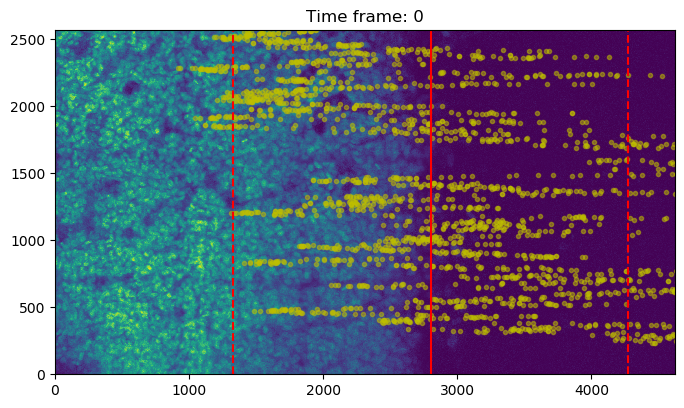

In [48]:
# Plot h(y) for single snapshot
t = 0;
h_y = hy_all[t];
h = h_all[t];
w = w_all[t];
signal_all = img_sliced[t];
y_vals = np.arange(Ly);

plt.figure(figsize=(8,8), dpi=100);
plt.imshow(signal_all); # also plot original picture
plt.plot(h_y, y_vals, 'y.', alpha=0.5);
plt.plot([h, h], [0, Ly], 'r-');
plt.plot([h-w, h-w], [0, Ly], 'r--');
plt.plot([h+w, h+w], [0, Ly], 'r--');
plt.set_cmap('viridis');
plt.xlim([0, Lx])
plt.ylim([0, Ly])
plt.title('Time frame: {}'.format(t))

# Save image
fname_out = folder_figures + im_label + "snapshot_time_frame_" + str(t);
label = '_method_3';
# plt.savefig(fname_out + label + ".pdf")
# plt.savefig(fname_out + label + ".png")

plt.show()

#### Validity of assumption of monotonic function

# Interface dynamics

### Interface height h(t) - h(0)

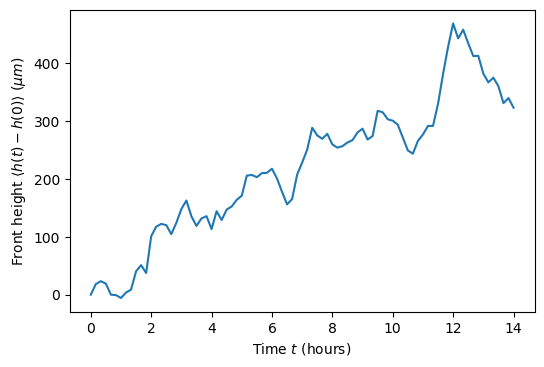

In [50]:
# Plot result
t_all = np.arange(t_max)/6; 
heights_all_norm = (-sign)*(h_all - h_all[0])/pix_per_micron; # (1) normalize by initial position, (2) flip sign if needed

h = plt.figure(dpi = 100);
#plt.plot(t_all, heights_all_1, label='(1) $L^{-1} \int_{0}^{L_y} h(y,t) dy$')
plt.plot(t_all, heights_all_norm, label='(2) $\int_{0}^{L_x} x (- \partial_X \phi_X(x, t)) dx$')
plt.xlabel('Time $t$ (hours)')
plt.ylabel('Front height $\\langle h(t) - h(0) \\rangle$ ($\mu m$)')
#plt.title('Compare methods 1 and 2')
#plt.legend()

# Plot power laws
# t_sel = np.arange(2, 16);
# exp = 0.06;
# c = 550;
# plt.plot(t_sel, c*(t_sel**exp), '--', label='power='+str(exp))

# Save image
fname_out = folder_figures + im_label + "interface_height_dynamics";
label = '_method_3';
plt.savefig(fname_out + label + ".pdf")
plt.savefig(fname_out + label + ".png")

plt.show()

### Interface width w(t) - w(0)

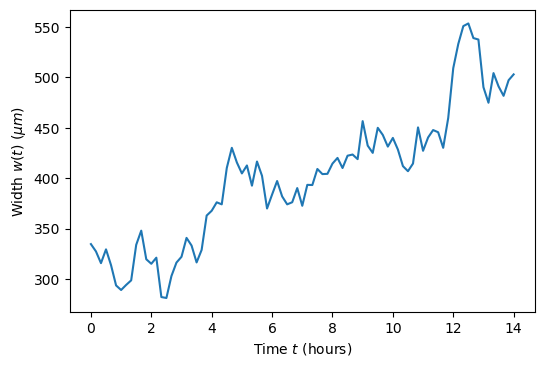

In [51]:
# Plot result and compare
t_all = np.arange(t_max)/6; 
widths_all = w_all/pix_per_micron;

h = plt.figure(dpi = 100);
#plt.plot(t_all, widths_all_1, label='(1) $<h(t)^2>  = L^{-1} \int h(y,t)^2\ dy$')
plt.plot(t_all, widths_all, label='(2) $<h(t)^2>  = 2 \int_{0}^{L_x} x\ \phi_X(x, t)\ dx$')
plt.xlabel('Time $t$ (hours)')
plt.ylabel('Width $w(t)$ ($\mu m$)')
#plt.title('Compare methods 1 and 2')
#plt.legend()

# Save image
fname_out = folder_figures + im_label + "interface_width_dynamics";
label = '_method_3';
plt.savefig(fname_out + label + ".pdf")
plt.savefig(fname_out + label + ".png")

plt.show()

### Save calculated data

In [53]:
# Save data for comparison with other methods
data_folder_2 = "/Users/dang/Documents/TablerLab/Data_Live_Imaging/Analyzed_height_vs_t/";
fname = "Video_{}_{}_interface_h_w_method_3.csv".format(video, date);

data_out = pd.DataFrame([heights_all_norm, widths_all], index=["height", "width"]).T;
data_out.to_csv(data_folder_2 + fname)

## Reduction to 1D interface dynamics
Instead of using the full interface definition, which is very noisy, map the data onto a 1D signal and define interface height based on this. <br>

Define $S_X(x) = \int S(x, y) dy$, normalization term $W = \int S_X(x) dx$, and $P[h] = \pm \partial_x S_X(x)/W$. The first and second moment follow as <br>

$\langle h \rangle = \int x \partial_x S_X(x)/W dx$ <br>
$\langle h^2 \rangle = \int x^2 \partial_x S_X(x)/W dx$

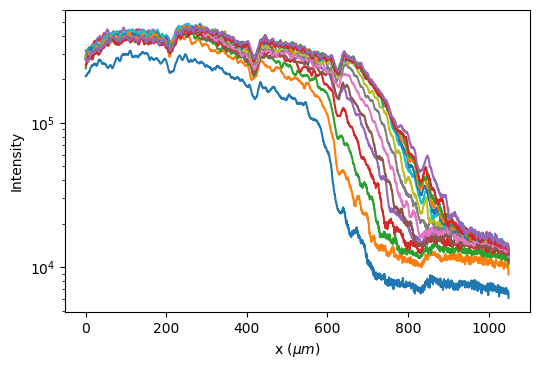

In [61]:
# Plot all intensity profiles
#t_idx = 0;
t_sel = np.arange(0, t_max, 6); #range(t_max);
x_max = intensity_vs_x.shape[0];
plt.figure(dpi=100)
for t_idx in t_sel:
    #print(t_idx);
    signal_all = img_sliced[t_idx];
    intensity_vs_x = np.sum(signal_all, axis=0)
    plt.plot(np.arange(x_max)/pix_per_micron, intensity_vs_x[:x_max])

plt.xlabel('x ($\mu m$)')
plt.ylabel('Intensity')   
plt.yscale('log')
plt.show();

In [62]:
# Calculate heights and widths
sign = -1; # CAUTION: sign=1 if intensities increase with x, -1 if decrease
t_idx = 0;

h_avg_all = np.zeros(t_max);
w_avg_all = np.zeros(t_max);

for t_idx in range(t_max):
    signal_all = img_sliced[t_idx];
    intensity_vs_x = np.sum(signal_all, axis=0);
    W = sign*(intensity_vs_x[-1] - intensity_vs_x[0]); # normalization
    del_x_S = np.diff(intensity_vs_x); # derivative of signal
    x_all = np.arange(1/2, Lx-1); # list of x coordinates
    
    # calculate height and width
    h_avg = np.sum(x_all*sign*del_x_S)/W;
    #print(h_avg/pix_per_micron)
    h2_avg = np.sum(x_all**2*sign*del_x_S)/W**2;
    w_avg = np.sqrt(h2_avg - h_avg**2);
    #print(w_avg/pix_per_micron)
    
    # store results
    h_avg_all[t_idx] = h_avg;
    w_avg_all[t_idx] = w_avg;

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


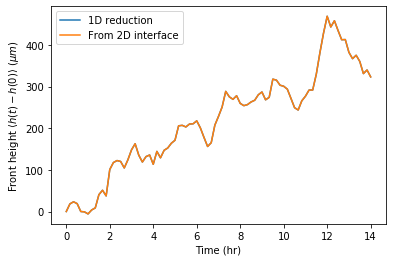

In [63]:
t_all = np.arange(t_max)/6;
h_avg_all_norm = (h_avg_all-h_avg_all[0])/pix_per_micron;

plt.figure()
plt.plot(t_all, h_avg_all_norm, label='1D reduction')
plt.plot(t_all, heights_all_norm, label='From 2D interface')
plt.xlabel('Time (hr)')
plt.ylabel('Front height $\\langle h(t) - h(0) \\rangle$ ($\mu m$)')
plt.legend()
plt.show();

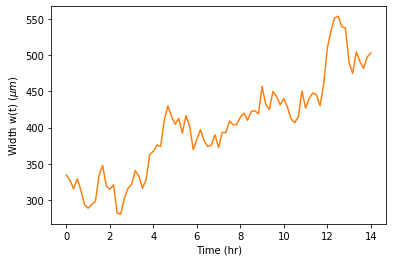

In [64]:
t_all = np.arange(t_max)/6;
w_avg_all_norm = w_avg_all/pix_per_micron;

plt.figure()
plt.plot(t_all, w_avg_all_norm, label='1D reduction')
plt.plot(t_all, widths_all, label='From 2D interface')
plt.xlabel('Time (hr)')
plt.ylabel('Width w(t) ($\mu m$)')

plt.show();

#### CONCLUSION: Methods identical! Operations commute!

# Calculate roughness

### Method 2: calculate exponent $\alpha$ from structure factor
We can also the scaling exponents from the dynamic structure factor <br>
$\hspace{1cm} S(k, t) = \langle \tilde{h}(k, t) \tilde{h}(-k, t) \rangle = k^{-(2\alpha + 1)} \tilde{s}(k t^{1/z}),$ <br>
$\hspace{1cm} \tilde{s}(u = kt^{1/z}) = \begin{cases} u^{-(2\alpha+1)} &\text{if } u \ll 1 \\ \text{const.} &\text{if } u \gg 1 \end{cases} $ <br> 

Here $\tilde{h}(k, t)$ denotes the Fourier transform of the interface height function $h(y, t)$ and $\langle \ldots \rangle$ the average over many instances (i.e. images). <br>

Obtain $\alpha$: <br>
For sufficiently large $k$, or at sufficiently large times $t$, $S(k, t)$ should scale as a power law and we can obtain the roughness coefficient $\alpha$ from this power law. <br>
 

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


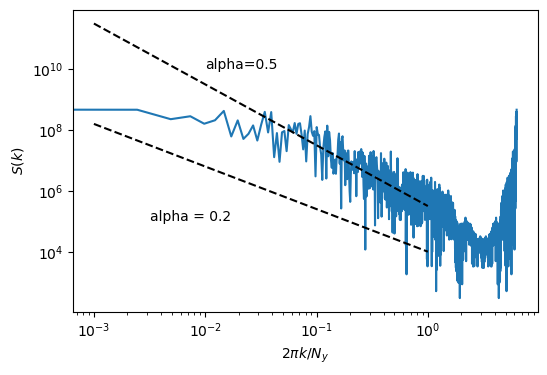

In [65]:
# Calculate for single image
t=70;
hy = hy_all[t];
k_all = 2*np.pi*np.arange(Ly)/Ly; # normalized 0 <= k <= 2*pi
S_all = fft.fft(hy)*fft.ifft(hy); # h(-k) obtained from inverse FFT
# NB subtracting mean leads to no change except k=0 mode vanishes

plt.figure(dpi=100)

# Plot dynamic structure factor S(k)
plt.plot(k_all, S_all)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$2\pi k/N_y$')
plt.ylabel('$S(k)$')

# Plot wave mode cut-off
# plt.plot([k_cell_norm, k_cell_norm], [10**(-5), 10**10], '--')
# plt.xlim(10**(-3.5),10**1)
# plt.ylim(10**(-3), 10**11)

# --- Plot power laws --- 
k_range = np.array([10**(-3), 10**(0)]);

alpha = 0.2;
c = (10**4);
S_range = c*k_range**(-2*alpha-1);
plt.plot(k_range, S_range, 'k--')
plt.text(10**(-2.5), 10**(5), 'alpha = ' + str( round(alpha, 3) ) )

alpha2 = 0.5;
c2 = (10**5.5)
S_range2 = c2*k_range**(-2*alpha2-1);
plt.plot(k_range, S_range2, 'k--')
plt.text(10**(-2), 10**10, 'alpha=' + str( round(alpha2, 3) ) )

# Save image
# fname_out = save_folder + im_label_0 + label_0 + "_structure_factor";
# ext = ".png";
# plt.savefig(fname_out + ext)

plt.show()

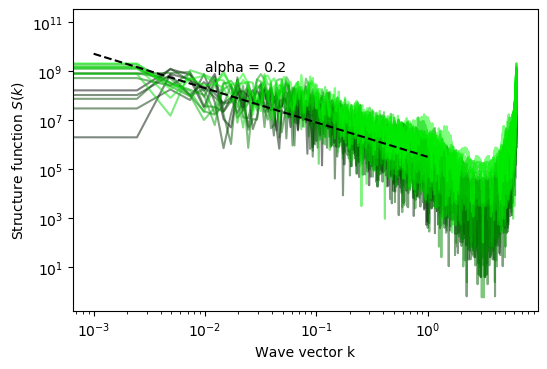

In [66]:
# Calculate for all images
t_selected = np.arange(0, t_max, 6);

k_all = 2*np.pi*np.arange(Ly)/Ly; # normalized 0 <= k <= 2*pi

plt.figure(dpi=100)
for idx in np.arange(len(t_selected)):    
    t = t_selected[idx];
    
    interface = hy_all[t];    
    h_all = interface[~np.isnan(interface)]; # filter out nan
    
    this_S_all = fft.fft(h_all)*fft.ifft(h_all); # h(-k) obtained from inverse FFT
    plt.plot(k_all, np.real(this_S_all), color=[0, t/t_max, 0, 0.5] )  
    
    #this_label = "t = " + str(t/6) + 'h';
    #plt.plot(this_S_all, label=this_label)  

# Plot power laws 
k_range = np.array([10**(-3), 10**(0)]);

alpha = 0.2;
c = (10**5.5);
S_range = c*k_range**(-2*alpha-1);
plt.plot(k_range, S_range, 'k--')
plt.text(10**(-2), 10**(9), 'alpha = ' + str( round(alpha, 3) ) )

# alpha2 = 0.5;
# c2 = (10**5.5)
# S_range2 = c2*k_range**(-2*alpha2-1);
# plt.plot(k_range, S_range2, 'k--')
# plt.text(10**(-2), 10**10, 'alpha=' + str( round(alpha2, 3) ) )

plt.xscale('log')
plt.yscale('log')
#plt.title('Structure function from 1 image')
plt.xlabel('Wave vector k')
plt.ylabel('Structure function $S(k)$')
#plt.legend()

# Save image
# fname_out = folder_figures + im_label + "structure_factor_all_brighter_is_later_t";
# plt.savefig(fname_out + ".pdf")
# plt.savefig(fname_out + ".png")

plt.show()

#### Convert between k and length scale
X-axis value of $x = 2\pi k/N_y$, so $k = \frac{x N_y}{2\pi}$. Length scale in pixels is $N_y/k = 2 \pi/x$. Length scale in microns is then $\frac{2 \pi }{x} \frac{1}{ \text{pix_per_micron}}$.

In [136]:
x = 10**(-2) #10**(0);
print("x = {}, Length scale = {} microns".format(x, (2*np.pi/x)/pix_per_micron ))

x = 0.01, Length scale = 142.7996660722633 microns


#### (2) Calculate dynamic exponent z
Plot $S(k, t) k^{(2\alpha + 1)} = \tilde{s}(u)$ against $u = k t^{1/z}$ on log-log scale. For well-chosen z, the curves at different times should collapse.

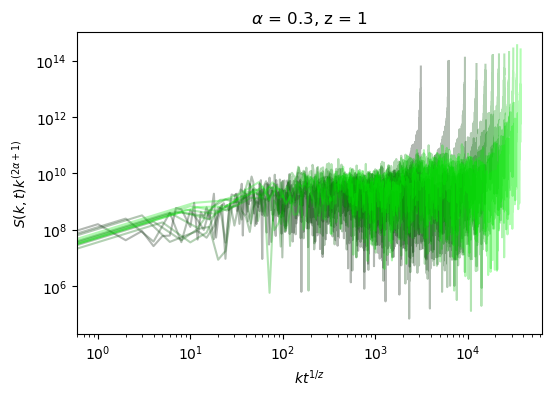

In [122]:
alpha = 0.3; # Assume alpha fixed
z = 1; # try a value of z
del_t = 1/6; # time step in real time
t_sel = np.arange(0, t_max, 6); # time in frames
k_max_all = np.zeros(len(t_sel));

plt.figure(dpi=100)
for idx in range(len(t_sel)):    
    tf = t_sel[idx]; # index of time frame
    
    # Calculate S(k)
    interface = hy_all[tf];
    h_all = interface[~np.isnan(interface)]; # filter out nan
    
    # internal check
    k_max_all[idx] = len(h_all);
    
    # set up x and y axis variables
    this_k_all = np.arange(len(h_all)); # start at k=1
    this_S_all = fft.fft(h_all)*fft.ifft(h_all); # h(-k) obtained from inverse FFT
    
    # Plot
    plt.plot(this_k_all*(tf*del_t)**(1/z), np.real(this_S_all)*(this_k_all**(2*alpha+1)), color=[0, tf/t_max, 0, 0.3] )  
    plt.title('$\\alpha$ = ' + str(alpha) + ', z = ' + str(z))

#plt.xlim(10**(0), 10**2.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$kt^{1/z}$')
plt.ylabel('$S(k, t)k^{(2\\alpha+1)}$')

plt.show()
# Save image
# fname_out = save_folder + im_label + "rescaled_Sk_for_z" + str(z) + "_brighter_is_later_t";
# plt.savefig(fname_out + ".pdf")
# plt.savefig(fname_out + ".png")